# MLP Model Evaluation

In [1]:
import yaml, glob
import pandas as pd
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
import tqdm
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from cartopy import crs as ccrs
from cartopy import feature as cfeature
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels 
import logging
from sklearn.utils import class_weight
from collections import OrderedDict
from callbacks import get_callbacks
from plotting import plot_confusion_matrix
from metrics import average_acc, ece, balanced_ece
from reliability import reliability_diagram, reliability_diagrams, compute_calibration
from seed import seed_everything

2022-07-24 15:08:00.060535: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/glade/work/jwillson/conda-envs/winter-ptype/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Build model and load saved weights

In [14]:
model_name = 'mping_072022'

# load config file
config = f'config/{model_name}.yml'
with open(config) as f:
    conf = yaml.load(f, Loader=yaml.FullLoader)

# load data
df = pd.read_parquet(conf['data_path'])
    
# model config
features = conf['tempvars'] + conf['tempdewvars'] + conf['ugrdvars'] + conf['vgrdvars']
outputs = conf['outputvars']
n_splits = conf['trainer']['n_splits']
train_size1 = conf['trainer']['train_size1'] # sets test size
train_size2 = conf['trainer']['train_size2'] # sets valid size
seed = conf['trainer']['seed']
num_hidden_layers = conf['trainer']['num_hidden_layers']
hidden_size = conf['trainer']['hidden_size']
dropout_rate = conf['trainer']['dropout_rate']
batch_size = conf['trainer']['batch_size']
ra_weight = conf['trainer']['ra_weight']
sn_weight = conf['trainer']['sn_weight']
pl_weight = conf['trainer']['pl_weight']
fzra_weight = conf['trainer']['fzra_weight']
class_weights = {0:ra_weight, 1:sn_weight, 2:pl_weight, 3:fzra_weight}
learning_rate = conf['trainer']['learning_rate']
# metrics = conf['trainer']['metrics']
activation = conf['trainer']['activation']
run_eagerly = conf['trainer']['run_eagerly']
shuffle = conf['trainer']['shuffle']
epochs = conf['trainer']['epochs']
label_smoothing = conf['trainer']['label_smoothing']
image_path = f"{conf['image_path']}{model_name}/"
dataset = conf['dataset']

# set seed
seed_everything(seed)

### Preprocess Data

In [3]:
# split and preprocess the data
df['day'] = df['datetime'].apply(lambda x: str(x).split(' ')[0])
    
splitter = GroupShuffleSplit(n_splits=n_splits, train_size=train_size1, random_state=seed)
train_idx, test_idx = list(splitter.split(df, groups=df['day']))[0]
train_data, test_data = df.iloc[train_idx], df.iloc[test_idx]
    
splitter = GroupShuffleSplit(n_splits=n_splits, train_size=train_size2, random_state=seed)
train_idx, valid_idx = list(splitter.split(train_data, groups=train_data['day']))[0]
train_data, valid_data = train_data.iloc[train_idx], train_data.iloc[valid_idx]
    
scaler_x = StandardScaler()
x_train = scaler_x.fit_transform(train_data[features])
x_valid = scaler_x.transform(valid_data[features])
x_test = scaler_x.transform(test_data[features])
y_train = train_data[outputs].to_numpy()
y_valid = valid_data[outputs].to_numpy()
y_test = test_data[outputs].to_numpy()

### Load saved splits

In [15]:
x_test = np.load(f'/glade/work/jwillson/{dataset}_data/{dataset}_x_test.npy')
y_test = np.load(f'/glade/work/jwillson/{dataset}_data/{dataset}_y_test.npy')

In [16]:
def build_model(input_size, hidden_size, num_hidden_layers, output_size):
    model = tf.keras.models.Sequential()
        
    if activation == 'leaky':
        model.add(tf.keras.layers.Dense(input_size))
        model.add(tf.keras.layers.LeakyReLU())
        
        for i in range(num_hidden_layers):
            if num_hidden_layers == 1:
                model.add(tf.keras.layers.Dense(hidden_size))
                model.add(tf.keras.layers.LeakyReLU())
            else:
                model.add(tf.keras.layers.Dense(hidden_size))
                model.add(tf.keras.layers.LeakyReLU())
                model.add(tf.keras.layers.Dropout(dropout_rate))
    else:
        model.add(tf.keras.layers.Dense(input_size, activation=activation))
        
        for i in range(num_hidden_layers):
            if num_hidden_layers == 1:
                model.add(tf.keras.layers.Dense(hidden_size, activation=activation))
            else:
                model.add(tf.keras.layers.Dense(hidden_size, activation=activation))
                model.add(tf.keras.layers.Dropout(dropout_rate))
        
    model.add(tf.keras.layers.Dense(output_size, activation='softmax'))
    
    return model
    
model = build_model(len(features), hidden_size, num_hidden_layers, len(outputs))
model.build((batch_size, len(features)))
model.summary()

model.load_weights(f'/glade/work/jwillson/{model_name}.h5')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (15620, 268)              72092     
                                                                 
 leaky_re_lu (LeakyReLU)     (15620, 268)              0         
                                                                 
 dense_9 (Dense)             (15620, 105)              28245     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (15620, 105)              0         
                                                                 
 dropout_6 (Dropout)         (15620, 105)              0         
                                                                 
 dense_10 (Dense)            (15620, 105)              11130     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (15620, 105)             

### Predict on test set using saved model

In [17]:
predictions = model.predict(x_test)

probs = np.max(predictions, 1)
preds = np.argmax(predictions, 1)
labels = np.argmax(y_test, 1)
print((preds == labels).mean())
print(average_acc(y_test, predictions))

2181/2181 [==============================] - 2s 863us/step
0.7979709688050783
0.7033631265954191


## Visualize results

### Confusion Matrices

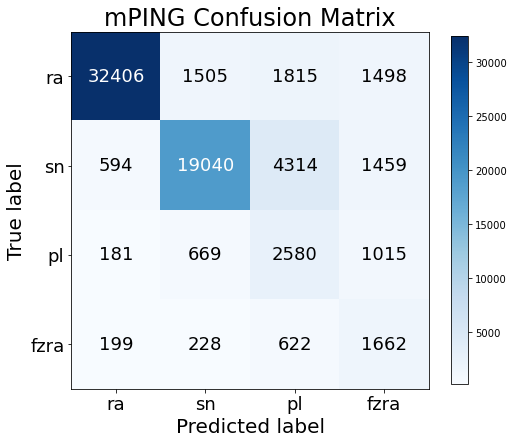

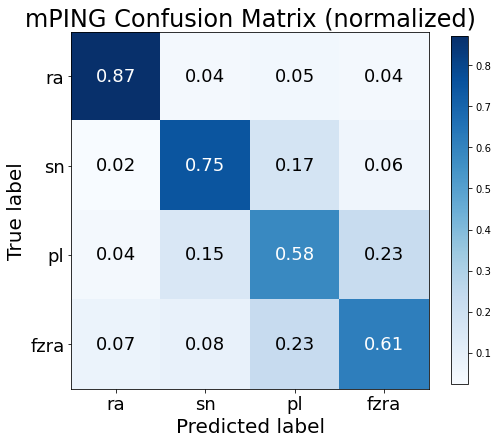

In [18]:
np.set_printoptions(precision=2)
class_names = ['ra', 'sn', 'pl', 'fzra']

# Plot non-normalized confusion matrix
plot_confusion_matrix(labels, preds, class_names, model_name,
                      title=f'{dataset} Confusion Matrix', filename='cm.png')

# Plot normalized confusion matrix
plot_confusion_matrix(labels, preds, class_names, model_name, normalize=True,
                      title=f'{dataset} Confusion Matrix (normalized)', filename='cm_norm.png')

plt.show()

### Reliability Diagrams

/glade/u/home/jwillson/winter-ptype/code/reliability.py:175: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(new_ticks)


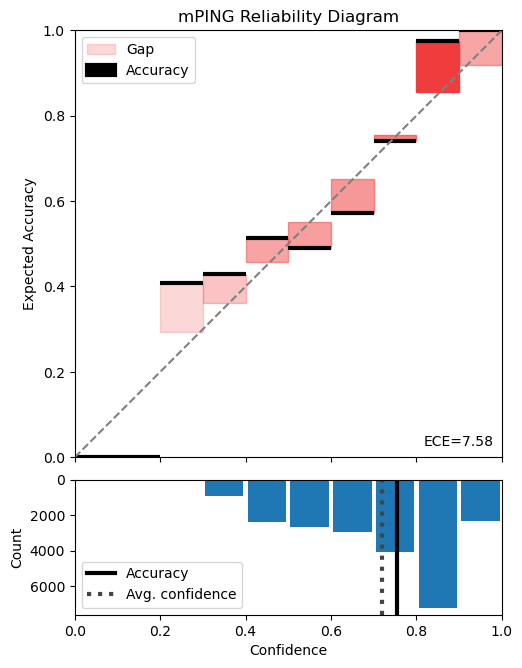

In [39]:
test_data = pd.DataFrame.from_dict(
        {"pred_labels": preds,
    "true_labels": labels, 
    "pred_conf": probs})

title = f"{dataset} Reliability Diagram"
fig = reliability_diagram(
    test_data["true_labels"].to_numpy(),
    test_data["pred_labels"].to_numpy(),
    test_data["pred_conf"].to_numpy(),
    num_bins=10, draw_ece=True,
    draw_bin_importance="alpha", draw_averages=True,
    title=title, figsize=(5, 5), dpi=100,
    return_fig=True)

# plt.savefig(f'{image_path}reliability.png', dpi=300, bbox_inches='tight')
plt.show()

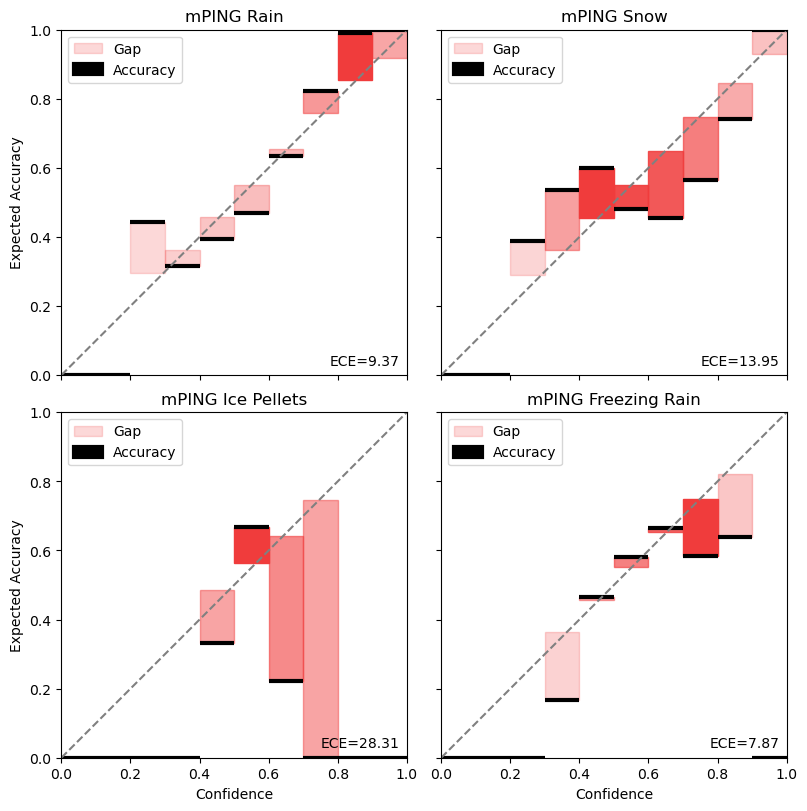

In [40]:
ptypes = [f'{dataset} Rain', f'{dataset} Snow', f'{dataset} Ice Pellets', f'{dataset} Freezing Rain']
cond0 = (test_data["true_labels"] == 0)
cond1 = (test_data["true_labels"] == 1)
cond2 = (test_data["true_labels"] == 2)
cond3 = (test_data["true_labels"] == 3)
results = OrderedDict()
results[ptypes[0]] = {
    "true_labels": test_data[cond0]["true_labels"].values,
    "pred_labels": test_data[cond0]["pred_labels"].values,
    "confidences": test_data[cond0]["pred_conf"].values
}
results[ptypes[1]] = {
    "true_labels": test_data[cond1]["true_labels"].values,
    "pred_labels": test_data[cond1]["pred_labels"].values,
    "confidences": test_data[cond1]["pred_conf"].values
}
results[ptypes[2]] = {
    "true_labels": test_data[cond2]["true_labels"].values,
    "pred_labels": test_data[cond2]["pred_labels"].values,
    "confidences": test_data[cond2]["pred_conf"].values
}
results[ptypes[3]] = {
    "true_labels": test_data[cond3]["true_labels"].values,
    "pred_labels": test_data[cond3]["pred_labels"].values,
    "confidences": test_data[cond3]["pred_conf"].values
}
fig = reliability_diagrams(results, num_bins=10, draw_bin_importance="alpha", num_cols=2, dpi=100, return_fig=True)
# plt.savefig(f'{image_path}class_reliability.png', dpi=300, bbox_inches='tight')
plt.show()

/glade/scratch/jwillson/ipykernel_194902/1609546589.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([1.2, 1.0, 0.8, 0.6, 0.4, 0.2, 0.0])


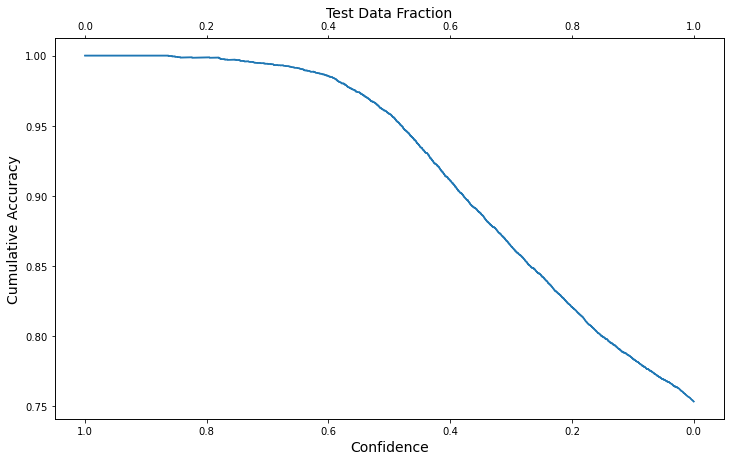

In [41]:
def compute_cov(df, col = "pred_conf", quan = "uncertainty", ascending = False):
    df = df.copy()
    df = df.sort_values(col, ascending = ascending)
    df["dummy"] = 1
    df[f"cu_{quan}"] = df[quan].cumsum() / df["dummy"].cumsum()
    df[f"cu_{col}"] = df[col].cumsum() / df["dummy"].cumsum()
    df[f"{col}_cov"] = df["dummy"].cumsum() / len(df)
    return df

test_data["acc"] = (test_data["pred_labels"] == test_data["true_labels"]).to_numpy()
test_data_sorted = compute_cov(test_data, col = "pred_conf", quan = "acc")

fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(1, 1, 1)
ax.plot(
    test_data_sorted["pred_conf_cov"],
    test_data_sorted["cu_acc"]
)
ax.set_xticklabels([1.2, 1.0, 0.8, 0.6, 0.4, 0.2, 0.0])

ax2 = ax.twiny()
ax2.set_xlabel("Test Data Fraction", fontsize=14)
ax2.plot(
    test_data_sorted["pred_conf_cov"],
    test_data_sorted["cu_acc"]
)
ax.set_ylabel("Cumulative Accuracy", fontsize=14)
ax.set_xlabel("Confidence", fontsize=14)

# plt.savefig(f'{image_path}acc_vs_cov.png', dpi=300, bbox_inches='tight')
plt.show()

/glade/scratch/jwillson/ipykernel_194902/3460424719.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([1.2, 1.0, 0.8, 0.6, 0.4, 0.2, 0.0])


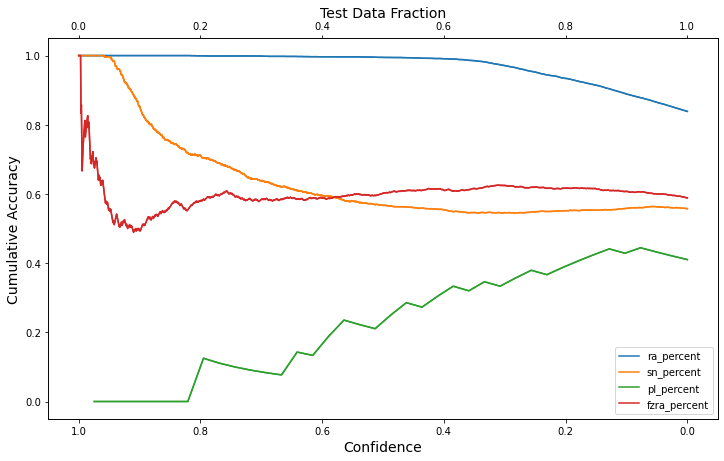

In [42]:
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(1, 1, 1)
ax2 = ax.twiny()
for c in [cond0, cond1, cond2, cond3]:
    _test_data_sorted = compute_cov(test_data[c], col = "pred_conf", quan = "acc")
    ax.plot(
        _test_data_sorted["pred_conf_cov"],
        _test_data_sorted["cu_acc"]
    )
    ax2.plot(
        _test_data_sorted["pred_conf_cov"],
        _test_data_sorted["cu_acc"]
    )

ax.set_xticklabels([1.2, 1.0, 0.8, 0.6, 0.4, 0.2, 0.0])
ax.set_ylabel("Cumulative Accuracy", fontsize=14)
ax2.set_xlabel("Test Data Fraction", fontsize=14)
ax.set_xlabel("Confidence", fontsize=14)
ax.legend(outputs)
# plt.savefig(f'{image_path}class_acc_vs_cov.png', dpi=300, bbox_inches='tight')
plt.show()

## Case Studies

In [43]:
timeframe = 'nov2015'
upsampling = 'none'
scale = 0.15

In [44]:
df = pd.read_parquet(f"/glade/work/jwillson/{timeframe}.parquet")
x_test = np.load(f"/glade/work/jwillson/{timeframe}_xtest.npy")
y_test = np.load(f"/glade/work/jwillson/{timeframe}_ytest.npy")

predictions = model.predict(x_test)

probs = np.max(predictions, 1)
preds = np.argmax(predictions, 1)
labels = np.argmax(y_test, 1)
print((preds == labels).mean())
print(average_acc(y_test, predictions))

264/264 [==============================] - 0s 844us/step
0.8456344035066935
0.6649510956229435


In [45]:
df["pred_label"] = preds
df["true_label"] = labels 
df["pred_conf"] = probs

In [46]:
latN = 54.0
latS = 20.0
lonW = -63.0
lonE = -125.0
cLat = (latN + latS)/2
cLon = (lonW + lonE )/2
colors = {0:'lime', 1:'dodgerblue', 2:'red', 3:'black'}

/glade/scratch/jwillson/ipykernel_194902/3525553789.py:30: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend(colors.values(), labels=["Rain", "Snow", "Ice Pellets", "Freezing Rain"], fontsize=24, markerscale=3, loc="lower right")


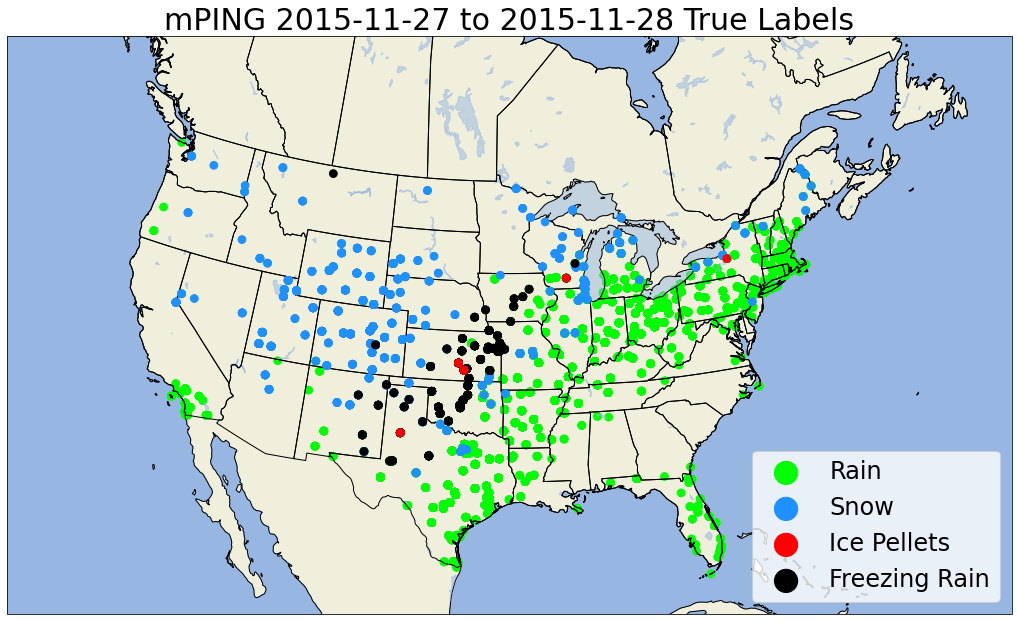

In [47]:
proj = ccrs.LambertConformal(central_longitude=cLon, central_latitude=cLat)
res = '50m'  # Coarsest and quickest to display; other options are '10m' (slowest) and '50m'.
fig = plt.figure(figsize=(18, 12))
ax = plt.subplot(1, 1, 1, projection=proj)
ax.set_extent([lonW, lonE, latS, latN])
ax.add_feature(cfeature.LAND.with_scale(res))
ax.add_feature(cfeature.OCEAN.with_scale(res))
ax.add_feature(cfeature.COASTLINE.with_scale(res))
ax.add_feature(cfeature.LAKES.with_scale(res), alpha=0.5)
ax.add_feature(cfeature.STATES.with_scale(res))

zorder = [1,2,4,3]
if dataset == 'ASOS':
    df['rand_lon'] = [df['lon'].to_numpy()[i]+np.random.normal(scale=scale) for i in range(len(df['lon']))]
    df['rand_lat'] = [df['lat'].to_numpy()[i]+np.random.normal(scale=scale) for i in range(len(df['lat']))]
    for i in range(4):
        ax.scatter(df["rand_lon"][df["true_label"] == i]-360,
                   df["rand_lat"][df["true_label"] == i],
                   c=df["true_label"][df["true_label"] == i].map(colors),
                   s=3, transform=ccrs.PlateCarree(), zorder=zorder[i])
else:
    for i in range(4):
        ax.scatter(df["lon"][df["true_label"] == i]-360,
                   df["lat"][df["true_label"] == i],
                   c=df["true_label"][df["true_label"] == i].map(colors),
                   s=60, transform=ccrs.PlateCarree(), zorder=zorder[i])

first_day = str(min(df['datetime'])).split(' ')[0]
last_day = str(max(df['datetime'])).split(' ')[0]
plt.legend(colors.values(), labels=["Rain", "Snow", "Ice Pellets", "Freezing Rain"], fontsize=24, markerscale=3, loc="lower right")
plt.title(f"{dataset} {first_day} to {last_day} True Labels", fontsize=30)
plt.savefig(f'{image_path}{timeframe}_truelabels.png', dpi=300, bbox_inches='tight')
plt.show()

/glade/scratch/jwillson/ipykernel_194902/199154872.py:30: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend(colors.values(), labels=["Rain", "Snow", "Ice Pellets", "Freezing Rain"], fontsize=24, markerscale=3, loc="lower right")


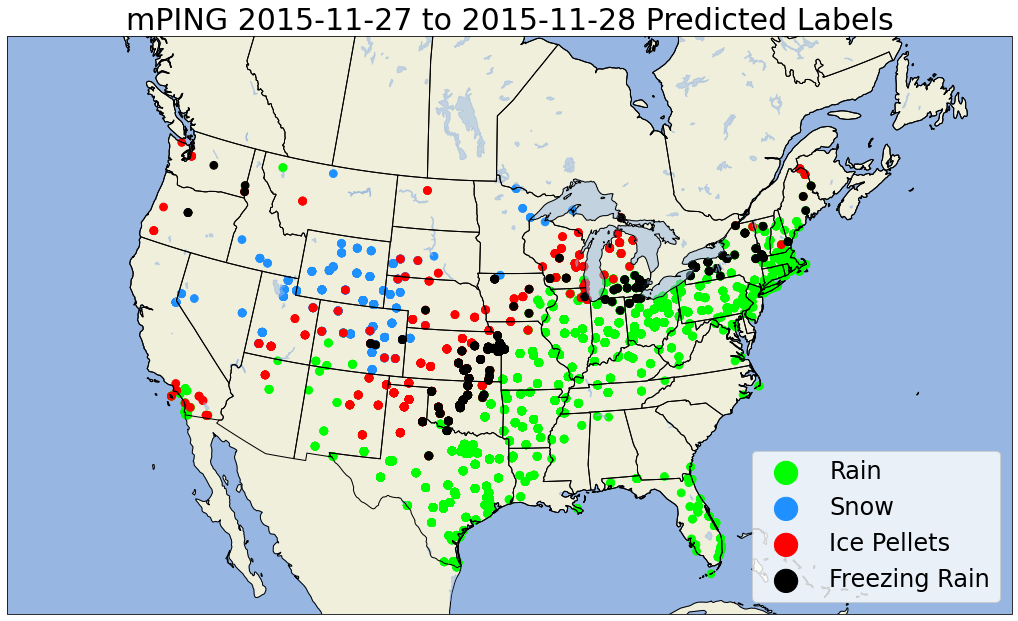

In [48]:
proj = ccrs.LambertConformal(central_longitude=cLon, central_latitude=cLat)
res = '50m'  # Coarsest and quickest to display; other options are '10m' (slowest) and '50m'.
fig = plt.figure(figsize=(18, 12))
ax = plt.subplot(1, 1, 1, projection=proj)
ax.set_extent([lonW, lonE, latS, latN])
ax.add_feature(cfeature.LAND.with_scale(res))
ax.add_feature(cfeature.OCEAN.with_scale(res))
ax.add_feature(cfeature.COASTLINE.with_scale(res))
ax.add_feature(cfeature.LAKES.with_scale(res), alpha=0.5)
ax.add_feature(cfeature.STATES.with_scale(res))

zorder = [1,2,4,3]
if dataset == 'ASOS':
    df['rand_lon'] = [df['lon'].to_numpy()[i]+np.random.normal(scale=scale) for i in range(len(df['lon']))]
    df['rand_lat'] = [df['lat'].to_numpy()[i]+np.random.normal(scale=scale) for i in range(len(df['lat']))]
    for i in range(4):
        ax.scatter(df["rand_lon"][df["pred_label"] == i]-360,
                   df["rand_lat"][df["pred_label"] == i],
                   c=df["pred_label"][df["pred_label"] == i].map(colors),
                   s=3, transform=ccrs.PlateCarree())
else:
    for i in range(4):
        ax.scatter(df["lon"][df["pred_label"] == i]-360,
                   df["lat"][df["pred_label"] == i],
                   c=df["pred_label"][df["pred_label"] == i].map(colors),
                   s=60, transform=ccrs.PlateCarree())

first_day = str(min(df['datetime'])).split(' ')[0]
last_day = str(max(df['datetime'])).split(' ')[0]
plt.legend(colors.values(), labels=["Rain", "Snow", "Ice Pellets", "Freezing Rain"], fontsize=24, markerscale=3, loc="lower right")
plt.title(f"{dataset} {first_day} to {last_day} Predicted Labels", fontsize=30)
plt.savefig(f'{image_path}{timeframe}_predlabels.png', dpi=300, bbox_inches='tight')
plt.show()

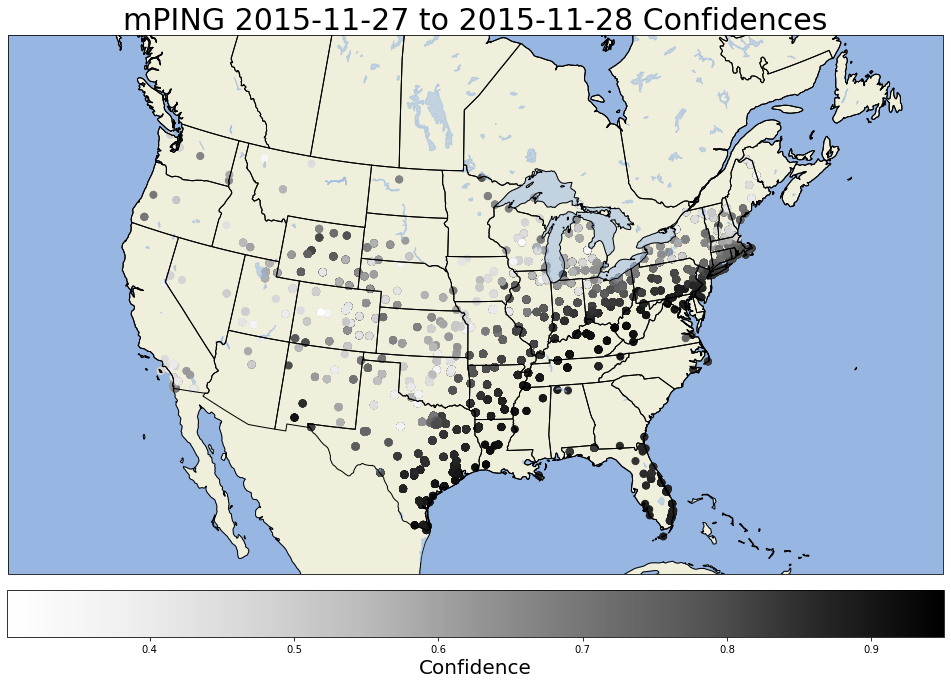

In [52]:
proj = ccrs.LambertConformal(central_longitude=cLon, central_latitude=cLat)
res = '50m'  # Coarsest and quickest to display; other options are '10m' (slowest) and '50m'.
fig = plt.figure(figsize=(18, 12))
ax = plt.subplot(1, 1, 1, projection=proj)
ax.set_extent([lonW, lonE, latS, latN])
ax.add_feature(cfeature.LAND.with_scale(res))
ax.add_feature(cfeature.OCEAN.with_scale(res))
ax.add_feature(cfeature.COASTLINE.with_scale(res))
ax.add_feature(cfeature.LAKES.with_scale(res), alpha=0.5)
ax.add_feature(cfeature.STATES.with_scale(res))

zorder = [1,2,4,3]
if dataset == 'ASOS':
    df['rand_lon'] = [df['lon'].to_numpy()[i]+np.random.normal(scale=scale) for i in range(len(df['lon']))]
    df['rand_lat'] = [df['lat'].to_numpy()[i]+np.random.normal(scale=scale) for i in range(len(df['lat']))]
    for i in range(4):
        sc = ax.scatter(df["rand_lon"][df["pred_label"] == i]-360,
                   df["rand_lat"][df["pred_label"] == i],
                   c=df["pred_conf"][df["pred_label"] == i],
                   s=3, transform=ccrs.PlateCarree(), cmap='Greys', 
                   vmin=df["pred_conf"].min(), vmax=df["pred_conf"].max())
else:
    for i in range(4):
        sc = ax.scatter(df["lon"][df["pred_label"] == i]-360,
                   df["lat"][df["pred_label"] == i],
                   c=df["pred_conf"][df["pred_label"] == i],
                   s=50, transform=ccrs.PlateCarree(), cmap='Greys', 
                   vmin=df["pred_conf"].min(), vmax=df["pred_conf"].max())

cbar = plt.colorbar(sc, orientation="horizontal", pad=0.025, shrink=0.9325)
cbar.set_label('Confidence',size=20)
plt.title(f"{dataset} {first_day} to {last_day} Confidences", fontsize=30)
plt.savefig(f'{image_path}{timeframe}_conf.png', dpi=300, bbox_inches='tight')
plt.show()